In [2]:
import numpy as np
from loadsimnc import load_sim
import matplotlib.pyplot as plt
import ffmpeg
import os
import matplotlib
from euler_model.simulator import Simulator1D
matplotlib.rcParams['text.usetex'] = True

g = 9.81
def calc_xpeak(eta):
    i = np.argmax(eta)
    searchrange = 3
    #work in x axis scaled by 1/dt;
    #want quadratic that best fits the data points (j, eta(j)) for j =i-2, ..., i+2
    polyfit_x = range(i-searchrange,i+searchrange)
    A = np.array([(1,j,j*j) for j in polyfit_x])
    b = np.array([eta[j] for j in polyfit_x])
    coefs = np.linalg.lstsq(A,b,rcond=-1)[0]
    return -coefs[1]/(2*coefs[2])

def load(fname):
    data = load_sim(fname)
    T = data['timeseries']['t']
    timepoints = len(T)
    x_peak = np.zeros(timepoints)
    c = np.zeros(timepoints)
    Fr = np.zeros(timepoints)
    #calculate x peaks and c
    for i,t in enumerate(T):
        x_peak[i] = data['dx'] * calc_xpeak(data['timeseries']['eta'][i])
        if i == timepoints - 1:
            c[i] = (x_peak[i] - x_peak[i-1])/(t - T[i-1])
        if i == 1:
            c[0] = (x_peak[i] - x_peak[0])/(t - T[0])
        elif i > 1:
            c[i-1] = (x_peak[i] - x_peak[i-2])/(t - T[i-2])
    for i in range(timepoints):
        Fr[i] = data['timeseries']['max_v'][i]/c[i]
    data['timeseries']['x_peak'] = x_peak
    data['timeseries']['c'] = c
    data['timeseries']['Fr'] = Fr
    
    return data

def get_u(sim, timeindex):
    mod = Simulator1D(-sim['data']['h'],sim['dt'],sim['dx'],
            sim['timeseries']['eta'][timeindex],sim['timeseries']['pS'][timeindex],
            P = sim['P'] if not sim['P'] is None else 0)
    return np.sqrt(
            mod.calculate_gradient(mod.phiS)**2 + \
            (1+mod.calculate_gradient(mod.eta)**2)* \
            (mod.vertvel(mod.eta, mod.phiS, mod.zeta,
                    mod.zeta_x, np.zeros(mod.Nx))**2)
        )

def get_etax(sim, timeindex):
    mod = Simulator1D(-sim['data']['h'],sim['dt'],sim['dx'],
            sim['timeseries']['eta'][timeindex],sim['timeseries']['pS'][timeindex],
            P = sim['P'] if not sim['P'] is None else 0)
    return mod.calculate_gradient(mod.eta)

def get_time_index(sim, time):
    return np.argmin(abs(sim['timeseries']['t'] - time))

# Figure 2: Wind-induced changes

Wave profile on $y$-axis with respect to distance on $x$-axis. Left column for $\frac{P_0}{\varepsilon_0} = 0.05, \beta = 0.015$ and right column for $\frac{P_0}{\varepsilon_0} = 0.025, \beta = 0.025$.


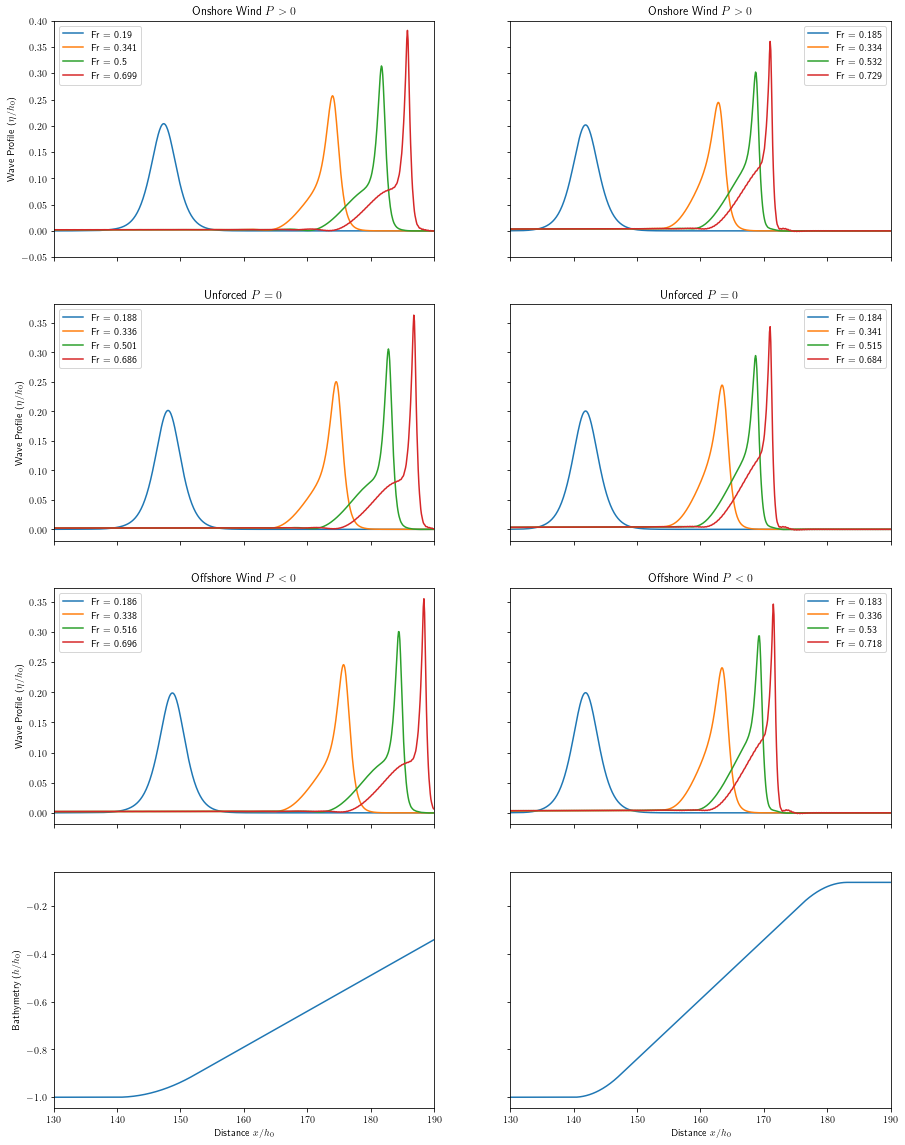

In [36]:
fig,axs = plt.subplots(nrows=4,ncols=2,sharex=True, sharey="row",figsize=[15,20])

simdata = [0,0]*3
simdata[0] = load("data/ZF2021/windslope_s0.015_P0.0507sim.nc")
simdata[1] = load("data/ZF2021/windslope_s0.025_P0.0253sim.nc")
simdata[2] = load("data/ZF2021/windslope_s0.015_P0sim.nc")
simdata[3] = load("data/ZF2021/windslope_s0.025_P0sim.nc")
simdata[4] = load("data/ZF2021/windslope_s0.015_P-0.0507sim.nc")
simdata[5] = load("data/ZF2021/windslope_s0.025_P-0.0253sim.nc")

x0 = 130
x1 = 190

y0 = -0.05
y1 = 0.4

for i in [0,1]:
    for k in [0,1,2]:
        #froude thresh time
        j = 0
        index_Fr_third = None
        index_Fr_half = None
        index_Fr_twothird = None
        timeseries = simdata[i+k*2]['timeseries']

        while j < len(timeseries['t']):
            if timeseries['Fr'][j] > 1/3 and index_Fr_third == None:
                index_Fr_third = j
            if timeseries['Fr'][j] > 1/2 and index_Fr_half == None:
                index_Fr_half = j
            if timeseries['Fr'][j] > 2/3 and index_Fr_twothird == None:
                index_Fr_twothird = j
            j += 1
        X = simdata[i+k*2]['data']['x']
        axs[k,i].plot(X,timeseries['eta'][index_Fr_third//2],label=f"Fr = {round(timeseries['Fr'][index_Fr_third//2],3)}")
        axs[k,i].plot(X,timeseries['eta'][index_Fr_third],label=f"Fr = {round(timeseries['Fr'][index_Fr_third],3)}")
        axs[k,i].plot(X,timeseries['eta'][index_Fr_half],label=f"Fr = {round(timeseries['Fr'][index_Fr_half],3)}")
        axs[k,i].plot(X,timeseries['eta'][index_Fr_twothird],label=f"Fr = {round(timeseries['Fr'][index_Fr_twothird],3)}")
        axs[k,i].legend()
        axs[k,0].set_ylabel(r"Wave Profile ($\eta/h_0$)")
    
    axs[0,i].set_title(r"Onshore Wind $P > 0$")
    axs[1,i].set_title(r"Unforced $P = 0$")
    axs[2,i].set_title(r"Offshore Wind $P < 0$")
    axs[3,0].set_ylabel(r"Bathymetry ($h/h_0$)")

    axs[3,i].plot(X,-simdata[i]['data']['h'])
    axs[3,i].set_xlabel(r"Distance $x/h_0$")
    axs[0,i].set_xlim((x0,x1))
    axs[0,i].set_ylim((y0,y1))



# Figure 3: Shoaling solitary wave profile, slope, velocity

$\frac{P_0}{\varepsilon_0} = 0.05, \beta = 0.015$. Column 1 is positive $P$, column 2 is negative $P$. Row 1 is profile $\eta/h_0$, row2 is slope $\frac{\partial \eta}{\partial x}$, row 3 is velocity $u/\sqrt{gh_0}$.

Times plotted: $t\sqrt{g/h_0} = 0, ~12.2, ~24.4$


Text(0.5, 1.0, 'Offshore Wind $P < 0$')

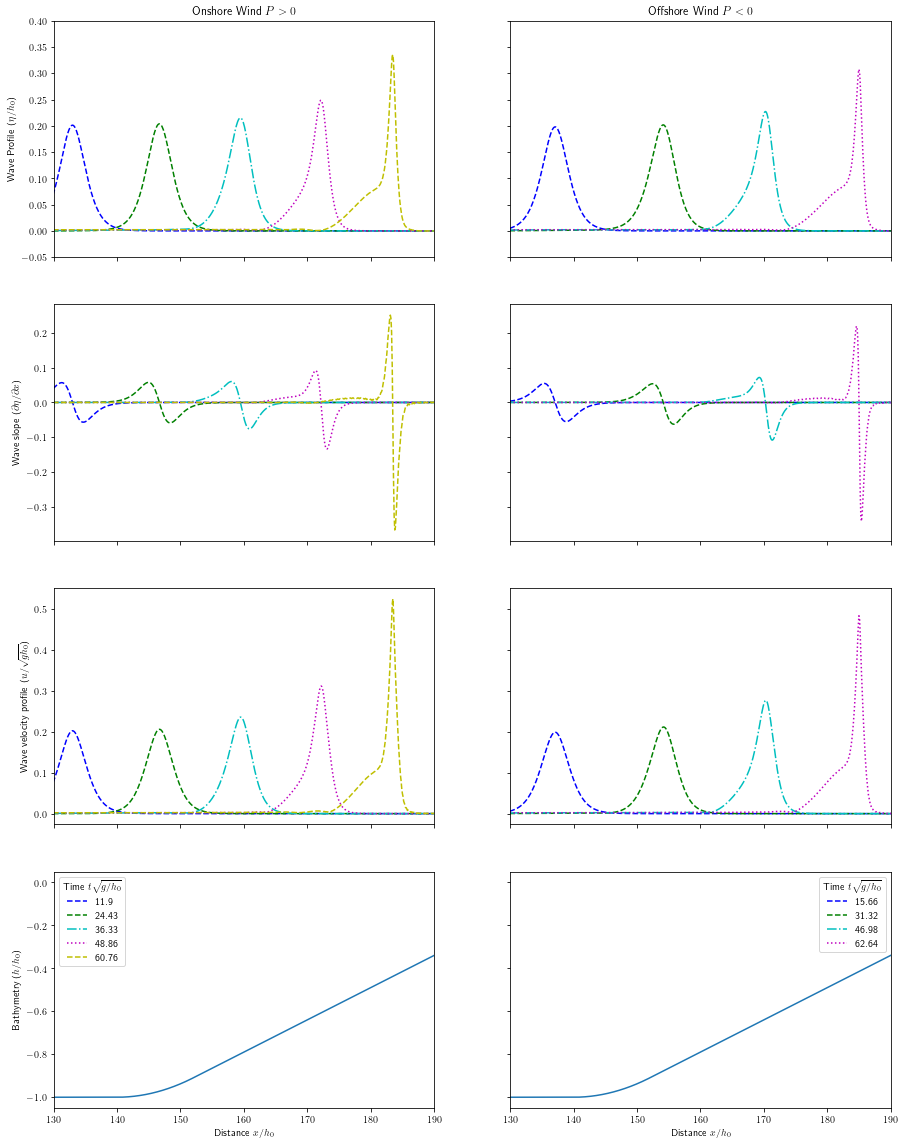

In [35]:
fig,axs = plt.subplots(nrows=4,ncols=2,sharex=True, sharey="row",figsize=[15,20])

simdata = [0,0]
simdata[0] = load("data/ZF2021/windslope_s0.015_P0.0507sim.nc")
simdata[1] = load("data/ZF2021/windslope_s0.015_P-0.0507sim.nc")

# multiply by nondimensional time
timescale = 1/(np.sqrt(g))

x0 = 130
x1 = 190

y0 = -0.05
y1 = 0.4

for i in [0,1]:
    #froude thresh time
    j = 0
    timeseries = simdata[i]['timeseries']

    T = []
    Tlab = ['--b','--g','-.c',':m','--y',':g']
    if i == 0:
        for t in [12.2,24.4,36.6,48.8,61]:
            T.append(get_time_index(simdata[i],t*timescale))
    else:
        for t in [15.6, 31.3, 31.3 + (31.3 - 15.6), 31.3 + 2*(31.3 - 15.6)]:
            T.append(get_time_index(simdata[i],t*timescale))

    X = simdata[i]['data']['x']
    for j in range(len(T)):
        axs[0,i].plot(X,timeseries['eta'][T[j]], Tlab[j])
        axs[1,i].plot(X,get_etax(simdata[i],T[j]), Tlab[j])
        axs[2,i].plot(X,get_u(simdata[i],T[j])/np.sqrt(g), Tlab[j])

    #axs[2,i].plot(timeseries['x_peak'], timeseries['c']/np.sqrt(g)/3, 'r')

    for j in range(len(T)):
        axs[3,i].plot([-0.5],[0], Tlab[j] ,label = f"{round(timeseries['t'][T[j]]/timescale,2)}")
    axs[3,i].legend(title=r"Time $t\sqrt{g/h_0}$")
    

    axs[3,i].plot(X,-simdata[i]['data']['h'])
    axs[3,i].set_xlabel(r"Distance $x/h_0$")
    axs[0,i].set_xlim((x0,x1))
    axs[0,i].set_ylim((y0,y1))

axs[0,0].set_ylabel(r"Wave Profile ($\eta/h_0$)")
axs[1,0].set_ylabel(r"Wave slope ($\partial\eta/\partial x$)")
axs[2,0].set_ylabel(r"Wave velocity profile ($u/\sqrt{gh_0}$)")
axs[3,0].set_ylabel(r"Bathymetry ($h/h_0$)")


axs[0,0].set_title(r"Onshore Wind $P > 0$")
axs[0,1].set_title(r"Offshore Wind $P < 0$")


# Figure 4: Shape statistics by pressure

These are for $\beta = 0.015$.


Plotted -0.0507
Plotted -0.0253
Plotted -0.0127
Plotted -0.00633
Plotted -0.00317
Plotted 0
Plotted 0.00317
Plotted 0.00633
Plotted 0.0127
Plotted 0.0253
Plotted 0.0507


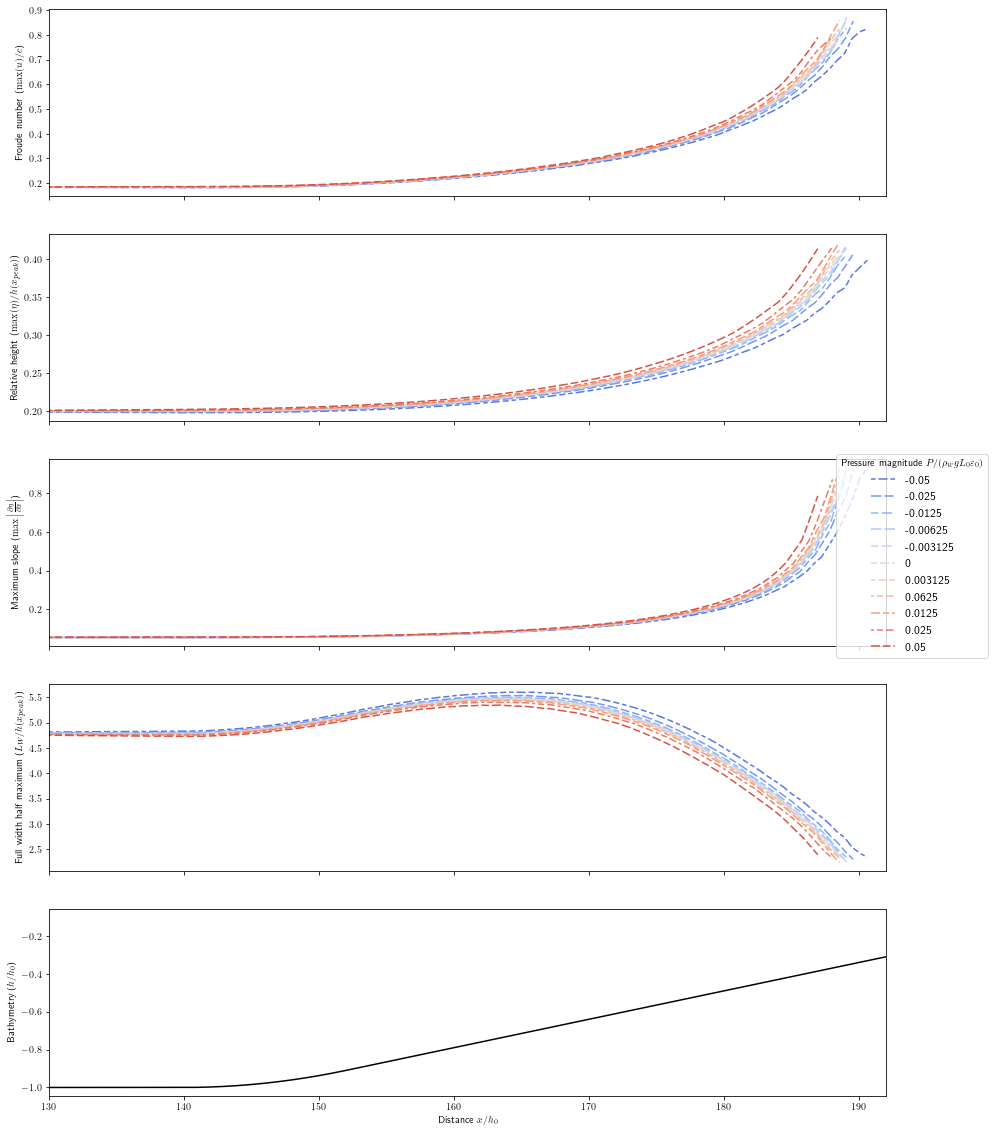

In [3]:
fig,axs = plt.subplots(nrows=5,ncols=1,sharex=True, sharey="row",figsize=[15,20])

pressure_labels = [-0.05,-0.025,-0.0125,-0.00625,-0.003125,0,0.003125,0.0625,0.0125,0.025,0.05]
pressures = ["-0.0507","-0.0253","-0.0127","-0.00633","-0.00317","0","0.00317","0.00633","0.0127","0.0253","0.0507"]
color_ = plt.cm.coolwarm(np.linspace(0.1,0.9, len(pressures))) # This returns RGBA; convert:
colors = ['#%02x%02x%02x' % (round(rgb[0]*255),round(rgb[1]*255),round(rgb[2]*255)) for rgb in color_]

x0 = 130
x1 = 192

lines = []

for i in range(len(pressure_labels)):
    sim = load(f"data/ZF2021/windslope_s0.015_P{pressures[i]}sim.nc")
    dashes = [
        np.random.randint(2,8), 2,
        np.random.randint(4,8), 2,
        np.random.randint(4,8), 2,
    ]
    series = sim['timeseries']
    line, = axs[0].plot(series['x_peak'],series['Fr'], '--',color=colors[i],label=f"{pressure_labels[i]}")
    line.set_dashes(dashes)
    line, = axs[1].plot(series['x_peak'],[
        np.max(series['eta'][t])/sim['data']['h'][round(series['x_peak'][t])]
        for t in range(len(series['x_peak']))
    ], '--',color=colors[i])
    line.set_dashes(dashes)
    line, = axs[2].plot(series['x_peak'],[
        max(abs(get_etax(sim,t)))
        for t in range(len(series['x_peak']))
    ], '--',color=colors[i])
    line.set_dashes(dashes)
    
    X = sim['data']['x']
    Z = np.zeros(sim['Nx'])
    I = np.ones(sim['Nx']) * max(X)

    dx = sim['dx']

    half_max_eta = np.array([
            np.max(series['eta'][t])/2
        for t,xpeak in enumerate(series['x_peak'])
    ])
    forward_half = [
            round(np.max(np.where(series['eta'][t] >= (half_max_eta[t]), X, Z))/dx)
        for t,xpeak in enumerate(series['x_peak'])
    ]
    #calculate true location: lerp
    sampledist = 1
    true_forward = [(guess + 
            (half_max_eta[t] - series['eta'][t][guess])/(series['eta'][t][guess + sampledist] - series['eta'][t][guess])
            /sampledist)*dx
        for t,guess in enumerate(forward_half)
    ]


    back_half = np.array([
            round(np.min(np.where(series['eta'][t] >= (half_max_eta[t]), X, I))/dx)
        for t,xpeak in enumerate(series['x_peak'])
    ])
    true_back = [(guess - 
            (half_max_eta[t] - series['eta'][t][guess])/(series['eta'][t][guess - sampledist] - series['eta'][t][guess])
            /sampledist)*dx
        for t,guess in enumerate(back_half)
    ]


    line, = axs[3].plot(series['x_peak'],[
        (true_forward[t] - true_back[t])/sim['data']['h'][round(xpeak/dx)]
        for t,xpeak in enumerate(series['x_peak'])
    ], '--',color=colors[i])
    line.set_dashes(dashes)
    print(f"Plotted {pressures[i]}")


axs[4].set_xlim((x0,x1))
    
axs[4].plot(sim['data']['x'],-sim['data']['h'], "k")
axs[0].set_ylabel(r"Froude number ($\max(u)/c$)")
axs[1].set_ylabel(r"Relative height ($\max(\eta)/h(x_{peak})$)")
axs[2].set_ylabel(r"Maximum slope ($\max\left|\frac{\partial\eta}{\partial x}\right|$)")
axs[3].set_ylabel(r"Full width half maximum ($L_W/h(x_{peak})$)")
axs[4].set_ylabel(r"Bathymetry ($h/h_0$)")
axs[4].set_xlabel(r"Distance $x/h_0$")
fig.legend(title=r"Pressure magnitude $P/(\rho_wgL_0\varepsilon_0)$",bbox_to_anchor=(1.0, 0.5), loc='center right',fontsize="large")



# Figure 5: Fractional change in pre-breaking zone


['#5977e3', '#90b2fe', '#c6d6f1', '#efcfbf', '#f59d7e', '#d65244']
